In [19]:
# %% [markdown]
# # 通用城市天气分析系统
# **通过修改 .env 文件即可切换任意城市**

# %% [code]
# 单元格1：动态加载配置
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 添加项目根目录
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# 导入通用模块
from config.config import config
from src.data_fetcher import UniversalWeatherFetcher

print(config)  # 显示当前配置


🌍 天气分析配置
────────────────
📍 目标城市: 桂林 (Guilin, CN)
📌 坐标: 纬度 25.2345, 经度 110.1799
🔑 API状态: ✅ 已配置
⚙️  缓存: 启用 (1小时)
📅 预报天数: 5天
🌐 语言: zh_cn


In [20]:

# %% [code]
# 单元格2：验证并初始化
if config.validate():
    print("✅ 配置验证通过！")
    fetcher = UniversalWeatherFetcher()
else:
    print("❌ 配置验证失败，请检查 .env 文件")
    


✅ 配置验证通过！


In [21]:
# %% [code]
# 单元格3：获取当前配置城市的天气
print(f"\n正在分析 {config.CITY_DISPLAY_NAME} 的天气...")
current_data = fetcher.get_current_weather()

if current_data:
    parsed_data = UniversalWeatherFetcher.parse_weather_data(
        current_data, 
        config.CITY_DISPLAY_NAME
    )
    
    print(f"\n📍 {config.CITY_DISPLAY_NAME} 实时天气")
    print("=" * 40)
    for key in ['当前温度(℃)', '天气状况', '湿度(%)', '风速(m/s)', '舒适度评级']:
        if key in parsed_data:
            print(f"{key:>10}: {parsed_data[key]}")
    print("=" * 40)



正在分析 桂林 的天气...
📂 使用缓存数据 (b961824c)

📍 桂林 实时天气
   当前温度(℃): 12.8
      天气状况: 晴朗
     湿度(%): 68
   风速(m/s): 1.26
     舒适度评级: 较为舒适


In [22]:

# %% [code]
# 单元格4：动态切换城市（无需修改代码）
def analyze_city(city_name=None, country_code=None, display_name=None):
    """动态分析指定城市"""
    if not city_name:
        city_name = config.CITY
    if not country_code:
        country_code = config.COUNTRY
    if not display_name:
        display_name = city_name
    
    print(f"🔍 正在分析 {display_name} ...")
    
    data = fetcher.get_current_weather(city_name, country_code)
    
    if data:
        parsed = UniversalWeatherFetcher.parse_weather_data(data, display_name)
        
        # 保存到文件（按城市命名）
        import pandas as pd
        df = pd.DataFrame([parsed])
        filename = f"../data/raw/{city_name.lower()}_weather.csv"
        # 确保数据目录存在
        data_dir = Path(filename).parent
        data_dir.mkdir(parents=True, exist_ok=True)
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"💾 数据已保存到: {filename}")
        
        return parsed
    return None

# 示例：动态分析不同城市
# 从cities_preset.json读取城市数据
import json
from pathlib import Path
from config.paths import paths

# 读取城市预设文件
preset_file = paths.CITIES_PRESET_FILE
with open(preset_file, 'r', encoding='utf-8') as f:
    cities_data = json.load(f)

# 转换为analyze_city函数需要的格式
cities_to_analyze = []
for city_id, city_info in cities_data['cities'].items():
    cities_to_analyze.append(
        {
            'city_name': city_info['name'],
            'country_code': city_info['country'],
            'display_name': city_info['display_name']
        }
    )

print(f"📋 从预设文件加载了 {len(cities_to_analyze)} 个城市")

all_results = []
for city_info in cities_to_analyze:
    result = analyze_city(**city_info)
    if result:
        all_results.append(result)


📋 从预设文件加载了 6 个城市
🔍 正在分析 北京 ...
📂 使用缓存数据 (21016bfe)
💾 数据已保存到: ../data/raw/beijing_weather.csv
🔍 正在分析 上海 ...
📂 使用缓存数据 (c4ee090d)
💾 数据已保存到: ../data/raw/shanghai_weather.csv
🔍 正在分析 广州 ...
📂 使用缓存数据 (5cdc860c)
💾 数据已保存到: ../data/raw/guangzhou_weather.csv
🔍 正在分析 深圳 ...
📂 使用缓存数据 (4aa934cd)
💾 数据已保存到: ../data/raw/shenzhen_weather.csv
🔍 正在分析 成都 ...
📂 使用缓存数据 (0487f187)
💾 数据已保存到: ../data/raw/chengdu_weather.csv
🔍 正在分析 桂林 ...
📂 使用缓存数据 (b961824c)
💾 数据已保存到: ../data/raw/guilin_weather.csv


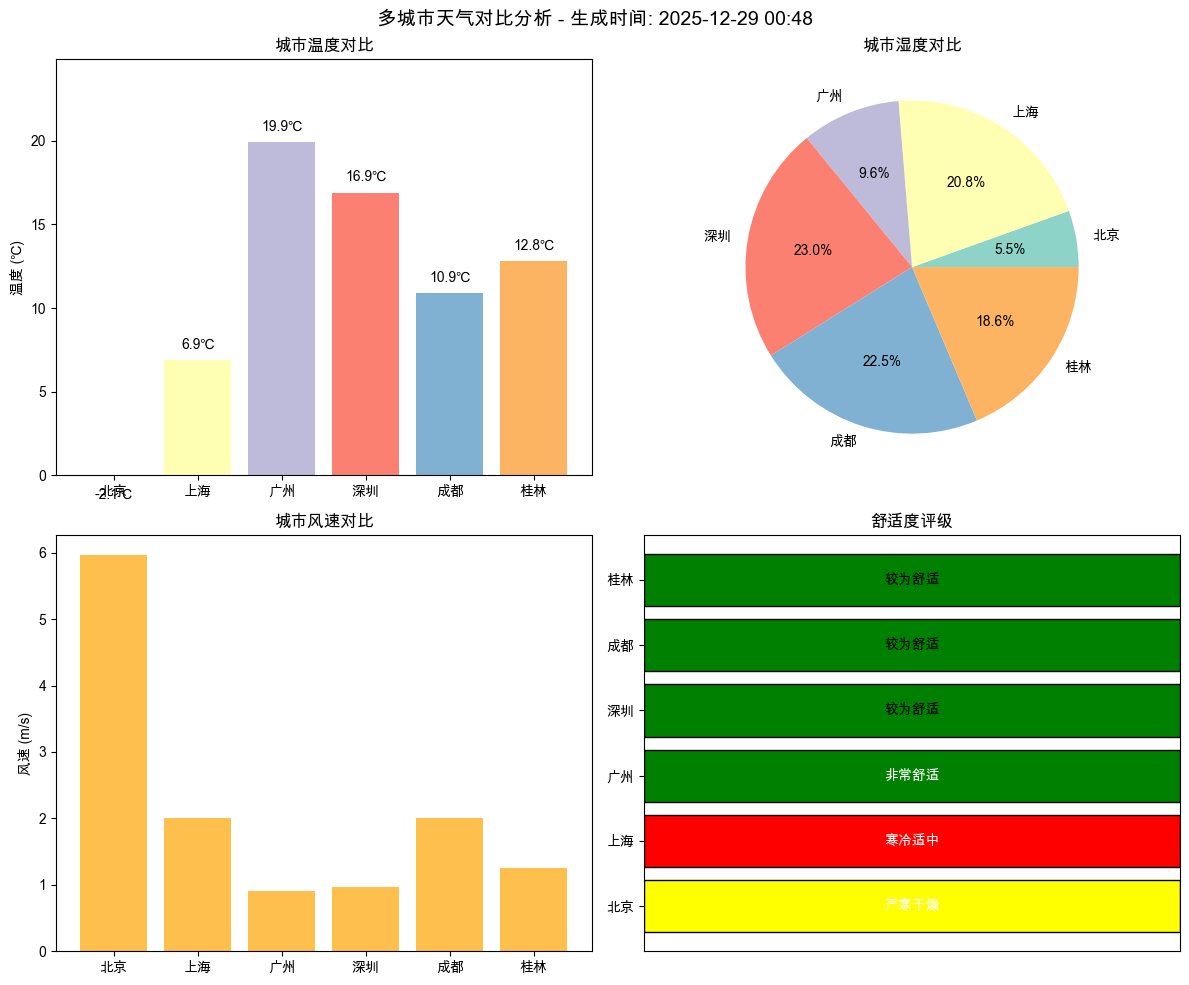

In [23]:

# %% [code]
# 单元格5：多城市对比可视化
if all_results:
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import numpy as np
    
    # 设置中文字体支持
    # 尝试多种中文字体，确保兼容性
    try:
        # 检测并使用可用的中文字体
        import matplotlib.font_manager
        chinese_fonts = []
        for font in matplotlib.font_manager.fontManager.ttflist:
            if 'SimHei' in font.name or 'Microsoft YaHei' in font.name or 'Heiti' in font.name or 'Arial Unicode' in font.name:
                chinese_fonts.append(font.name)
        
        if chinese_fonts:
            mpl.rcParams['font.family'] = chinese_fonts + ['sans-serif']
        else:
            # 回退方案：使用matplotlib默认的sans-serif字体
            mpl.rcParams['font.family'] = ['sans-serif']
    except:
        # 异常情况下使用默认设置
        mpl.rcParams['font.family'] = ['sans-serif']
    
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    
    # 转换为DataFrame
    df_comparison = pd.DataFrame(all_results)
    
    # 创建对比图表
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 温度对比
    cities = df_comparison['城市']
    temps = df_comparison['当前温度(℃)']
    
    # 使用动态颜色列表，适应任意数量的城市
    colors = plt.cm.Set3.colors[:len(cities)]
    bars = axes[0, 0].bar(cities, temps, color=colors)
    axes[0, 0].set_title('城市温度对比', fontweight='bold')
    axes[0, 0].set_ylabel('温度 (℃)')
    axes[0, 0].set_ylim(0, max(temps) + 5)
    
    # 添加温度值标签
    for bar, temp in zip(bars, temps):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{temp}℃', ha='center', va='bottom')
    
    # 湿度对比
    humidity = df_comparison['湿度(%)']
    wedges, texts, autotexts = axes[0, 1].pie(
        humidity, 
        labels=cities,
        autopct='%1.1f%%',
        colors=plt.cm.Set3.colors[:len(humidity)]
    )
    axes[0, 1].set_title('城市湿度对比', fontweight='bold')
    
    # 风速对比
    wind_speed = df_comparison['风速(m/s)']
    x_pos = np.arange(len(cities))
    axes[1, 0].bar(x_pos, wind_speed, color='orange', alpha=0.7)
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(cities)
    axes[1, 0].set_title('城市风速对比', fontweight='bold')
    axes[1, 0].set_ylabel('风速 (m/s)')
    
    # 舒适度评级
    comfort = df_comparison['舒适度评级']
    comfort_colors = []
    for rating in comfort:
        if '舒适' in rating:
            comfort_colors.append('green')
        elif '寒冷' in rating or '炎热' in rating:
            comfort_colors.append('red')
        else:
            comfort_colors.append('yellow')
    
    axes[1, 1].barh(cities, [1]*len(cities), color=comfort_colors, edgecolor='black')
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_xticks([])
    axes[1, 1].set_title('舒适度评级', fontweight='bold')
    
    # 添加评级文本
    for i, (city, rating) in enumerate(zip(cities, comfort)):
        axes[1, 1].text(0.5, i, rating, ha='center', va='center', 
                       fontweight='bold', color='white' if rating != '较为舒适' else 'black')
    
    plt.suptitle(f'多城市天气对比分析 - 生成时间: {pd.Timestamp.now().strftime("%Y-%m-%d %H:%M")}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# %% [markdown]
# ## 如何切换城市
# 
# 要分析其他城市，只需修改 `.env` 文件中的以下配置：
# 
# ```env
# WEATHER_CITY=Shanghai      # 改为目标城市英文名
# CITY_DISPLAY_NAME=上海     # 改为目标城市显示名
# WEATHER_COUNTRY=CN         # 国家代码
# ```
# 
# 修改后重新运行此笔记本即可！


In [24]:

# %% [code]
# 单元格6：生成城市切换工具函数
def quick_city_analysis(city_name, country_code='CN', display_name=None):
    """
    快速分析指定城市
    示例: quick_city_analysis('Guangzhou', 'CN', '广州')
    """
    if not display_name:
        display_name = city_name
    
    print(f"🚀 快速分析: {display_name}")
    print("-" * 30)
    
    data = fetcher.get_current_weather(city_name, country_code)
    
    if data:
        parsed = UniversalWeatherFetcher.parse_weather_data(data, display_name)
        
        # 显示关键信息
        info_template = "城市: {city}\n温度: {temp}℃ (体感: {feels_like}℃)\n天气: {weather} ({description})\n湿度: {humidity}%\n风速: {wind_speed} m/s\n舒适度: {comfort}\n更新时间: {update_time}".format(
            city=parsed['城市'],
            temp=parsed['当前温度(℃)'],
            feels_like=parsed['体感温度(℃)'],
            weather=parsed['天气状况'],
            description=parsed['详细描述'],
            humidity=parsed['湿度(%)'],
            wind_speed=parsed['风速(m/s)'],
            comfort=parsed['舒适度评级'],
            update_time=parsed['更新时间']
        )
        
        print(info_template)
        return parsed
    
    return None

# 示例使用
print("示例：快速分析不同城市")
print("=" * 40)
quick_city_analysis('Beijing', 'CN', '北京')
print()
quick_city_analysis('Hangzhou', 'CN', '杭州')

示例：快速分析不同城市
🚀 快速分析: 北京
------------------------------
📂 使用缓存数据 (21016bfe)
城市: 北京
温度: -2.1℃ (体感: -8.1℃)
天气: 晴朗 (晴)
湿度: 20%
风速: 5.97 m/s
舒适度: 严寒干燥
更新时间: 2025-12-29 00:19:46

🚀 快速分析: 杭州
------------------------------
📂 使用缓存数据 (fd30544d)
城市: 杭州
温度: 5.0℃ (体感: 3.1℃)
天气: 晴朗 (晴)
湿度: 62%
风速: 2.24 m/s
舒适度: 寒冷适中
更新时间: 2025-12-29 00:24:25


{'城市': '杭州',
 '实际城市名': 'Hangzhou',
 '国家': 'CN',
 '更新时间': '2025-12-29 00:24:25',
 '天气状况': '晴朗',
 '详细描述': '晴',
 '当前温度(℃)': 5.0,
 '体感温度(℃)': 3.1,
 '最高温度(℃)': 5.0,
 '最低温度(℃)': 5.0,
 '湿度(%)': 62,
 '气压(hPa)': 1020,
 '风速(m/s)': 2.24,
 '风向(°)': 211,
 '云量(%)': 0,
 '能见度(m)': 10000,
 '日出时间': '06:54:55',
 '日落时间': '17:07:19',
 '时区偏移': 28800,
 '数据来源': 'OpenWeatherMap',
 '舒适度评级': '寒冷适中'}